# Observed Stochastic Ys

Ys have the same # of observations needed to recapitulate the distribution fit.

"This is a special case of a stochastic variable that we call an observed stochastic, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, _indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model_."

# Inputs

In [1]:
import rnaseq_lib3 as r
import pandas as pd
import scipy.stats as st
import pymc3 as pm
import numpy as np
import time
import os
import pickle
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# Gene Fit Example

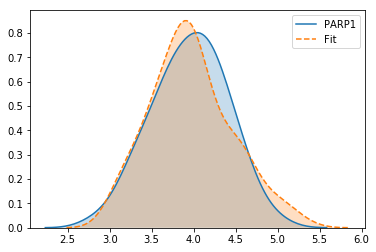

In [33]:
gene = 'PARP1'
gene_dist = normal[normal.tissue == 'Liver'][gene]
sns.kdeplot(gene_dist, label=gene, shade=True)
loc, scale = st.norm.fit(gene_dist)
sns.kdeplot(st.norm.rvs(loc=loc, scale=scale, size=100), label='Fit', shade=True, ls='--');

# Model Spec
Define inputs to model
- Sample
- Background dataset
- Training Genes

In [3]:
sample = tumor.loc['TCGA-FY-A3I4-01']
print(f"Sample comes from tissue: {sample.tissue}")
# We'll pick a subset of normal tissue for model training
test = normal
training_genes = r.outlier.select_k_best_genes(test, genes, 'tissue', 50)
classes = sorted(test.tissue.unique())
ncats = len(classes)
print(f'{ncats} background datasets and {len(training_genes)} genes')

Sample comes from tissue: Thyroid
20 background datasets and 50 genes


Prefit Ys

In [7]:
ys = {}
for gene in training_genes:
    for dataset in classes:
        name = f'{gene}-{dataset}'
        ys[name] = st.norm.fit(test[test.tissue == dataset][gene])    

Define Model

In [39]:
with pm.Model() as model:
    # PRIORS
    a =  pm.Normal('a', mu=0, sd=1)
    # Beta Coefficient
    mu_b = pm.Normal('mu_b', mu=0, sd=1)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=ncats)
    # Y Coefficient
    mu_y = pm.Normal('mu_y', mu=0, sd=10)
    sigma_y = pm.Normal('sigma_y', 2.1, 1)
    
    # Means
    y_params = {}
    mu = {}
    idx = test.tissue.astype('category').cat.codes
    for gene in training_genes:
        for dataset in classes:
            # Fit dataset and generate observations
            name = f'{gene}-{dataset}'
            cat_mu, cat_sd = ys[name]
            cat_obs = st.norm.rvs(loc=cat_mu, scale=cat_sd, size=500)
            y_params[name] = pm.Normal(name, 0, 1, observed=cat_obs)
        
        # Define mu
        mu[gene] = a
        for i, dataset in enumerate(classes):
            mu[gene] += b[i] * y_params[f'{gene}-{dataset}']
    
    # Model estimation
    eps = pm.InverseGamma('eps', 2.1, 1)
    z = {}
    for gene in training_genes:
        z[gene] = pm.Laplace(gene, mu=mu[gene], b=eps, observed=sample[gene])

# Run Model

In [40]:
out_dir = '/mnt/research_serializations/Observed-Stochastic-Ys'
out_path = os.path.join(out_dir, f'{sample.id}-normal.pkl')
if os.path.exists(out_path):
    normal_model = pickle.load(open(out_path, 'rb'))
    trace, model = normal_model['trace'], normal_model['model']
else:
    t0 = time.time()
    with model:
        trace = pm.sample(target_accept=0.9)
    runtime = (time.time() - t0) / 60
    # Save
    normal_model = {}
    normal_model['trace'], normal_model['model'] = trace, model
    with open(out_path, 'wb') as f:
        pickle.dump()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, sigma_y, mu_y, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 4000/4000 [43:03<00:00,  1.27s/draws]  
The acceptance probability does not match the target. It is 0.9046423808741337, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8864101834576339, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9362927208142128, but should be close to 0.8. Try to increase the number of tuning steps.


## Traceplot

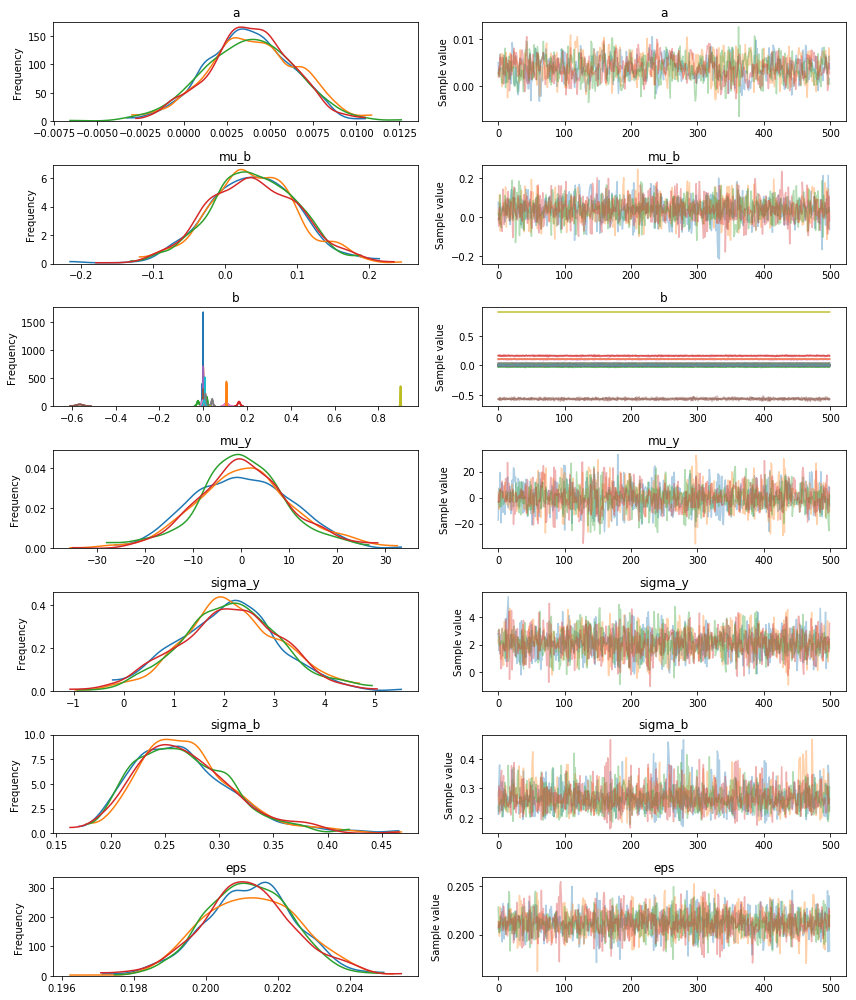

In [41]:
pm.traceplot(trace);

## Model Weight

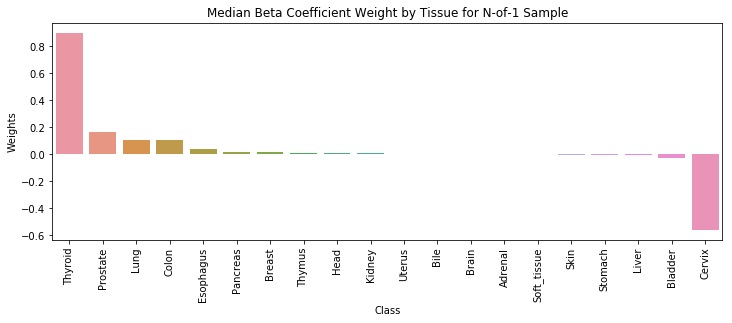

In [42]:
r.outlier.plot_weights(classes, trace)

## PPC

In [48]:
ppc = pm.sample_ppc(trace, model=model)

100%|██████████| 500/500 [05:43<00:00,  1.76it/s]


In [104]:
gene = 'SFTPA2'
y_gene = [x for x in ys if x.startswith(gene)]
b = trace['a']
for i, y_name in enumerate(y_gene):
    mu, sd = ys[y_name]
    b += trace['b'][:,i] * np.array(st.norm.rvs(mu, sd, size=2000))
z = np.random.laplace(loc=b, scale=trace['eps'])

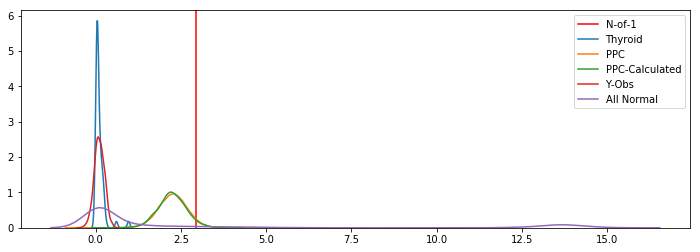

In [105]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], label='N-of-1', c='r')
sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], label='Thyroid')
sns.kdeplot(ppc[gene].ravel(), label='PPC')
sns.kdeplot(z, label='PPC-Calculated')

mu, sd = ys[f'{gene}-Thyroid']
sns.kdeplot(np.array(st.norm.rvs(mu, sd, size=2000)), label='Y-Obs')
sns.kdeplot(normal[gene], label='All Normal')

# LogitNormal

## Model Spec

In [108]:
with pm.Model() as model_logit:
    # PRIORS
    a =  pm.Normal('a', mu=0, sd=1)
    # Beta Coefficient
    mu_b = pm.Normal('mu_b', mu=0, sd=1)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    b = pm.LogitNormal('b', mu=mu_b, sd=sigma_b, shape=ncats)
    # Y Coefficient
    mu_y = pm.Normal('mu_y', mu=0, sd=10)
    sigma_y = pm.Normal('sigma_y', 2.1, 1)
    
    # Means
    y_params = {}
    mu = {}
    fits = {}
    idx = test.tissue.astype('category').cat.codes
    for gene in training_genes:
        for dataset in classes:
            # Fit dataset and generate observations
            name = f'{gene}-{dataset}'
            cat_mu, cat_sd = ys[name]
            cat_obs = st.norm.rvs(loc=cat_mu, scale=cat_sd, size=500)
            y_params[name] = pm.Normal(name, 0, 1, observed=cat_obs)
        
        # Define mu
        mu[gene] = a
        for i, dataset in enumerate(classes):
            mu[gene] += b[i] * y_params[f'{gene}-{dataset}']
    
    # Model estimation
    eps = pm.InverseGamma('eps', 2.1, 1)
    z = {}
    for gene in training_genes:
        z[gene] = pm.Laplace(gene, mu=mu[gene], b=eps, observed=sample[gene])

## Run Model

In [96]:
out_dir = '/mnt/research_serializations/Observed-Stochastic-Ys'
out_path = os.path.join(out_dir, f'{sample.id}-logit.pkl')
if os.path.exists(out_path):
    logit_model = pickle.load(open(out_path, 'rb'))
    trace_logit, model_logit = logit_model['trace'], logit_model['model']
else:
    t0 = time.time()
    with model_logit:
        trace_logit = pm.sample(target_accept=0.9)
    runtime = (time.time() - t0) / 60
    # Save
    logit_model = {}
    logit_model['trace'], logit_model['model'] = trace, model
    with open(out_path, 'wb') as f:
        pickle.dump(logit_model, f)

## Traceplot

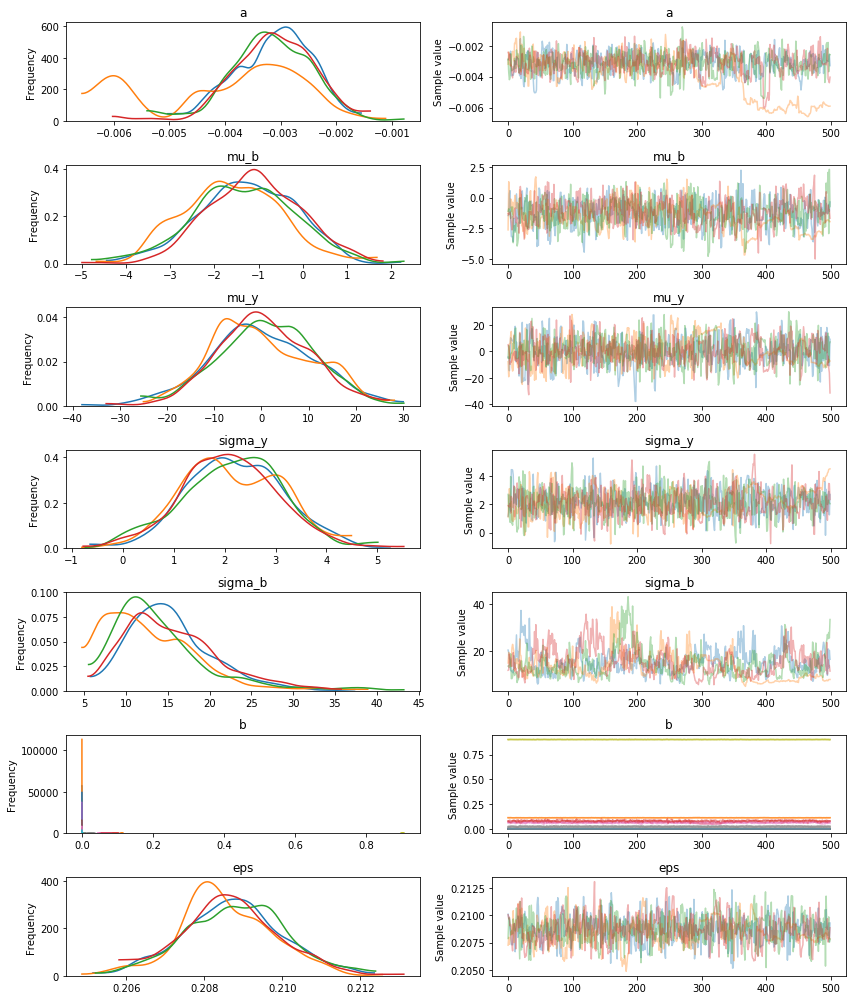

In [117]:
pm.traceplot(trace_logit);

## Model Weight

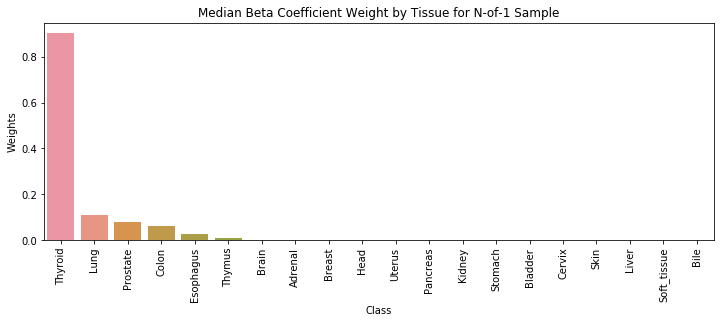

In [118]:
r.outlier.plot_weights(classes, trace_logit)

## PPC

In [27]:
ppc_logit = pm.sample_ppc(trace_logit, model=model_logit)

100%|██████████| 500/500 [06:31<00:00,  1.56it/s]


## Gene Example: SFTPC

In [22]:
gene = 'SFTPC'

### Figure for SFTPC - One at a Time

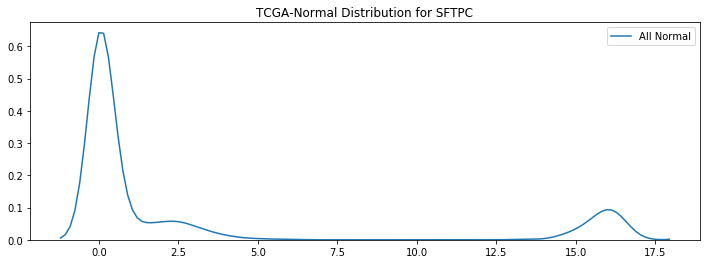

In [72]:
plt.figure(figsize=(12, 4))
sns.kdeplot(normal[gene], label='All Normal')
plt.title(f'TCGA-Normal Distribution for {gene}');

Add Thyroid

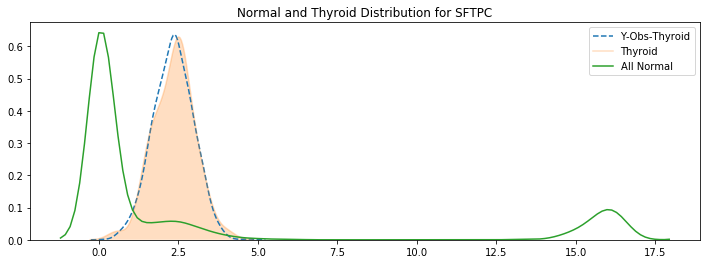

In [17]:
plt.figure(figsize=(12, 4))

mu, sd = ys[f'{gene}-Thyroid']
sns.kdeplot(np.array(st.norm.rvs(mu, sd, size=2000)), label='Y-Obs-Thyroid', ls='--')
sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], label='Thyroid', shade=True, alpha=0.25)

sns.kdeplot(normal[gene], label='All Normal')
plt.title(f'Normal and Thyroid Distribution for {gene}');

Add Lung

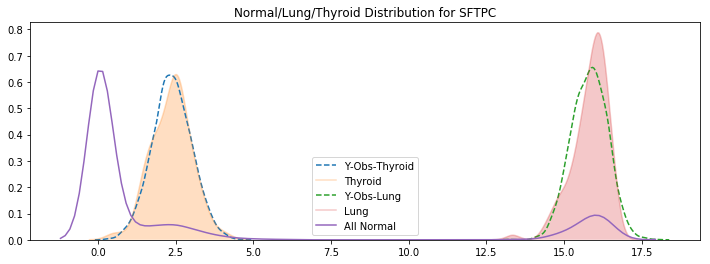

In [18]:
plt.figure(figsize=(12, 4))

mu, sd = ys[f'{gene}-Thyroid']
sns.kdeplot(np.array(st.norm.rvs(mu, sd, size=2000)), label='Y-Obs-Thyroid', ls='--')
sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], label='Thyroid', shade=True, alpha=0.25)

mu, sd = ys[f'{gene}-Lung']
sns.kdeplot(np.array(st.norm.rvs(mu, sd, size=2000)), label='Y-Obs-Lung', ls='--')
sns.kdeplot(normal[normal.tissue == 'Lung'][gene], label='Lung', shade=True, alpha=0.25)

sns.kdeplot(normal[gene], label='All Normal')
plt.title(f'Normal/Lung/Thyroid Distribution for {gene}');

Add PPC

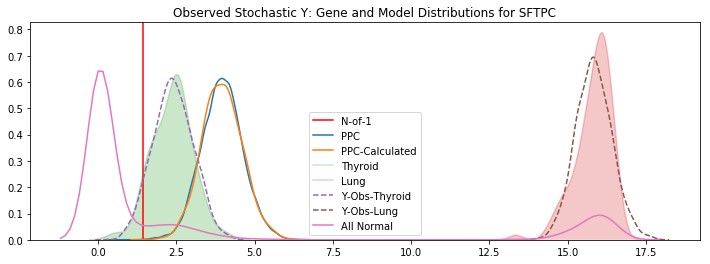

In [28]:
y_gene = [x for x in ys if x.startswith(gene)]
b = trace_logit['a']
for i, y_name in enumerate(y_gene):
    mu, sd = ys[y_name]
    b += trace_logit['b'][:,i] * np.array(st.norm.rvs(mu, sd, size=2000))
z = np.random.laplace(loc=b, scale=trace_logit['eps'])

plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], label='N-of-1', c='r')
sns.kdeplot(ppc_logit[gene].ravel(), label='PPC')
sns.kdeplot(z, label='PPC-Calculated')

sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], label='Thyroid', shade=True, alpha=0.25)
sns.kdeplot(normal[normal.tissue == 'Lung'][gene], label='Lung', shade=True, alpha=0.25)

mu, sd = ys[f'{gene}-Thyroid']
sns.kdeplot(np.array(st.norm.rvs(mu, sd, size=2000)), label='Y-Obs-Thyroid', ls='--')

mu, sd = ys[f'{gene}-Lung']
sns.kdeplot(np.array(st.norm.rvs(mu, sd, size=2000)), label='Y-Obs-Lung', ls='--')

sns.kdeplot(normal[gene], label='All Normal')
plt.title(f'Observed Stochastic Y: Gene and Model Distributions for {gene}');

## Gene Example: SFTPA2

In [141]:
gene = 'SFTPA2'
y_gene = [x for x in ys if x.startswith(gene)]
b = trace_logit['a']
for i, y_name in enumerate(y_gene):
    mu, sd = ys[y_name]
    b += trace_logit['b'][:,i] * np.array(st.norm.rvs(mu, sd, size=2000))
z = np.random.laplace(loc=b, scale=trace_logit['eps'])

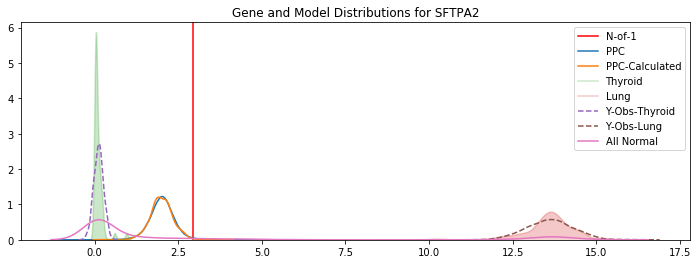

In [143]:
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], label='N-of-1', c='r')
sns.kdeplot(ppc_logit[gene].ravel(), label='PPC')
sns.kdeplot(z, label='PPC-Calculated')

sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], label='Thyroid', shade=True, alpha=0.25)
sns.kdeplot(normal[normal.tissue == 'Lung'][gene], label='Lung', shade=True, alpha=0.25)

mu, sd = ys[f'{gene}-Thyroid']
sns.kdeplot(np.array(st.norm.rvs(mu, sd, size=2000)), label='Y-Obs-Thyroid', ls='--')

mu, sd = ys[f'{gene}-Lung']
sns.kdeplot(np.array(st.norm.rvs(mu, sd, size=2000)), label='Y-Obs-Lung', ls='--')

sns.kdeplot(normal[gene], label='All Normal')
plt.title(f'Gene and Model Distributions for {gene}');

## Drug Gene Outside of Training Set

In [93]:
drug = 'MAP2K1'

In [94]:
ys = {}
for d in classes:
    ys[d] = st.norm.fit(normal[normal.tissue == d][drug])

In [97]:
b = trace_logit['a']
for i, y_name in enumerate(ys):
    mu, sd = ys[y_name]
    b += trace_logit['b'][:,i] * np.array(st.norm.rvs(mu, sd, size=len(trace_logit['a'])))
z = np.random.laplace(loc=b, scale=trace_logit['eps'])

Text(0.5, 1.0, 'MAP2K1')

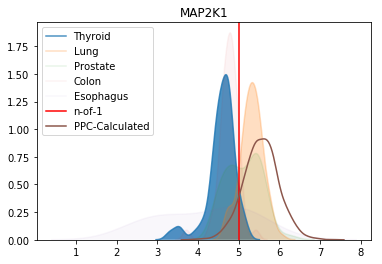

In [98]:
sns.kdeplot(normal[normal.tissue == 'Thyroid'][drug], label='Thyroid', shade=True, alpha=0.80)
mu, sd = ys['Thyroid']
#sns.kdeplot(st.norm.rvs(mu, sd, size=2000), label='Thyroid-Fit', ls='--')

sns.kdeplot(normal[normal.tissue == 'Lung'][drug], label='Lung', shade=True, alpha=0.25)
sns.kdeplot(normal[normal.tissue == 'Prostate'][drug], label='Prostate', shade=True, alpha=0.10)
sns.kdeplot(normal[normal.tissue == 'Colon'][drug], label='Colon', shade=True, alpha=0.05)
sns.kdeplot(normal[normal.tissue == 'Esophagus'][drug], label='Esophagus', shade=True, alpha=0.05)

mu, sd = ys['Lung']
#sns.kdeplot(st.norm.rvs(mu, sd, size=2000), label='Lung-Fit', ls='--')

plt.axvline(sample[drug], label='n-of-1', c='r')
sns.kdeplot(z, label='PPC-Calculated')
plt.title(f'{drug}')

# Swap Training Genes for Drug Genes

## Model Spec

In [105]:
ys = {}
for gene in drug_genes:
    for dataset in classes:
        name = f'{gene}-{dataset}'
        ys[name] = st.norm.fit(test[test.tissue == dataset][gene])    

In [106]:
with pm.Model() as model_drug:
    # PRIORS
    a =  pm.Normal('a', mu=0, sd=1)
    # Beta Coefficient
    mu_b = pm.Normal('mu_b', mu=0, sd=1)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    b = pm.LogitNormal('b', mu=mu_b, sd=sigma_b, shape=ncats)
    # Y Coefficient
    mu_y = pm.Normal('mu_y', mu=0, sd=10)
    sigma_y = pm.Normal('sigma_y', 2.1, 1)
    # Model Error
    eps = pm.InverseGamma('eps', 2.1, 1)
    
    # Means
    for gene in tqdm(drug_genes):
        # Start linear equation
        mu = a
        
        # Add B and Y components
        for i, dataset in enumerate(classes):
            # Fit dataset and generate observations
            name = f'{gene}-{dataset}'
            cat_mu, cat_sd = ys[name]
            cat_obs = st.norm.rvs(loc=cat_mu, scale=cat_sd, size=60)
            mu += b[i] * pm.Normal(name, 0, 1, observed=cat_obs)

        # Place mu in Laplacian
        pm.Laplace(gene, mu=mu, b=eps, observed=sample[gene])

## Run Model

In [107]:
out_dir = '/mnt/research_serializations/Observed-Stochastic-Ys'
out_path = os.path.join(out_dir, f'{sample.id}-drug-genes.pkl')
if os.path.exists(out_path):
    drug_model = pickle.load(open(out_path, 'rb'))
    trace_drug, model_drug = drug_model['trace'], drug_model['model']
else:
    t0 = time.time()
    with model_drug:
        trace_drug = pm.sample(target_accept=0.9)
    runtime = (time.time() - t0) / 60
    # Save
    drug_model = {}
    drug_model['trace'], drug_model['model'] = trace_drug, model_drug
    with open(out_path, 'wb') as f:
        pickle.dump(model_drug, f)

## Traceplot

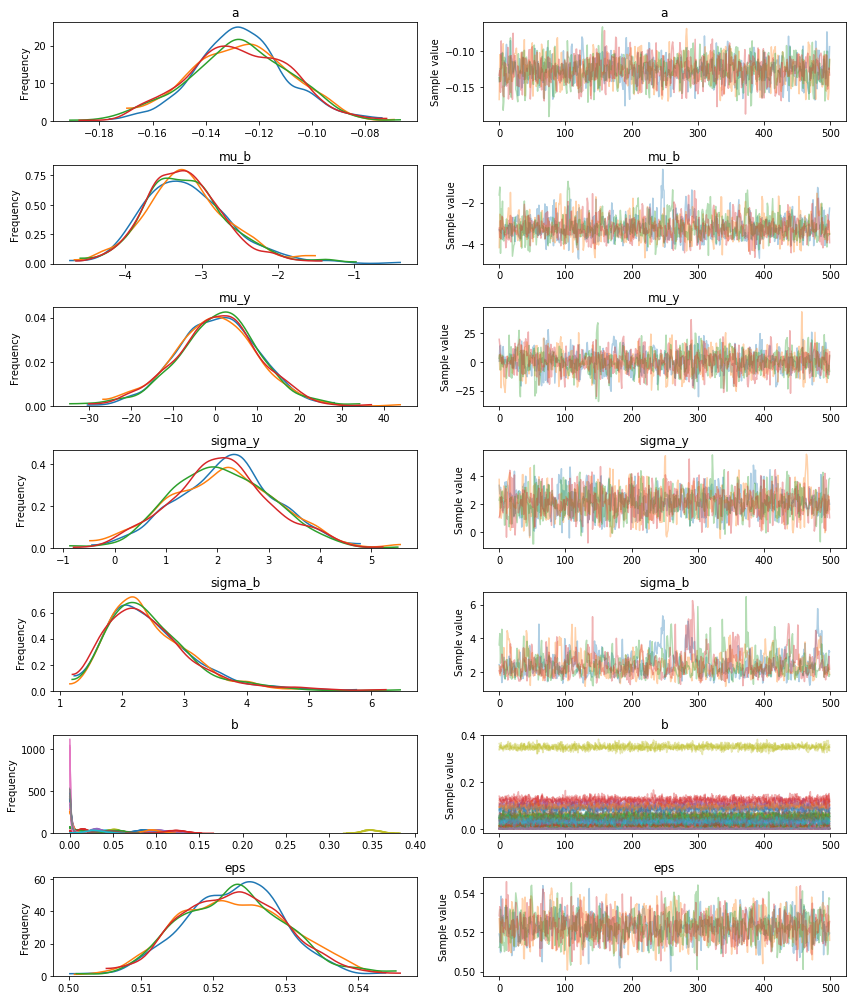

In [108]:
pm.traceplot(trace_drug);

## Model Weight

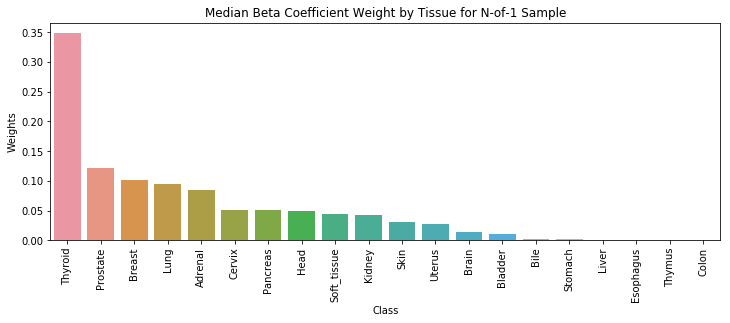

In [109]:
r.outlier.plot_weights(classes, trace_drug);

## PPC

### Gene Example: PIK3R2

In [44]:
#gene = 'PIK3R2'
#gene = 'MDM2'
gene = 'MAP2K1'

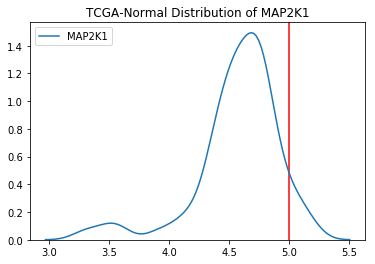

In [82]:
#gene = np.random.choice(drug_genes)
plt.axvline(sample[gene], c='r')
sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene])
plt.title(f'TCGA-Normal Distribution of {gene}');

Add Thyroid

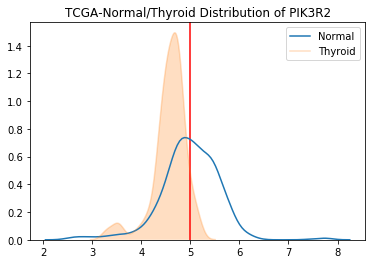

In [84]:
plt.axvline(sample[gene], c='r')
sns.kdeplot(normal[gene], label='Normal')

sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], label='Thyroid', shade=True, alpha=0.25)
plt.title('TCGA-Normal/Thyroid Distribution of PIK3R2');

Add Prostate

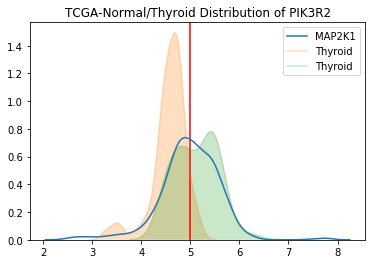

In [85]:
plt.axvline(sample[gene], c='r')
sns.kdeplot(normal[gene])

sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], label='Thyroid', shade=True, alpha=0.25)
sns.kdeplot(normal[normal.tissue == 'Prostate'][gene], label='Thyroid', shade=True, alpha=0.25)
plt.title('TCGA-Normal/Thyroid Distribution of PIK3R2');

Add PPC

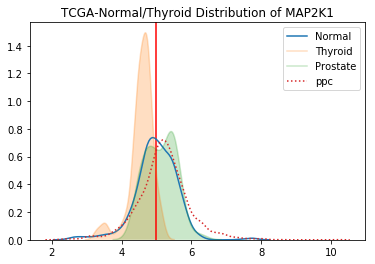

In [86]:
y_gene = [x for x in ys if x.startswith(gene)]
b = trace_drug['a']
for i, y_name in enumerate(y_gene):
    b += trace_drug['b'][:,i] * np.array(st.norm.rvs(*ys[y_name], size=2000))
z = np.random.laplace(loc=b, scale=trace_drug['eps'])


plt.axvline(sample[gene], c='r')
sns.kdeplot(normal[gene], label='Normal')

sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], label='Thyroid', shade=True, alpha=0.25)
sns.kdeplot(normal[normal.tissue == 'Prostate'][gene], label='Prostate', shade=True, alpha=0.25)
plt.title(f'TCGA-Normal/Thyroid Distribution of {gene}');
sns.kdeplot(z, label='ppc', ls=':')

# Separate Alphas per Linear Model

**DOES NOT CONVERGE**

## Model Spec

In [8]:
with pm.Model() as model_alpha:
    # PRIORS
    mu_a = pm.Normal('mu_a', 0, sd=10)
    sigma_a = pm.InverseGamma('sigma_a', 2.1, 1)
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=len(training_genes))
    # Beta Coefficient
    mu_b = pm.Normal('mu_b', mu=0, sd=1)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    b = pm.LogitNormal('b', mu=mu_b, sd=sigma_b, shape=ncats)
    # Y Coefficient
    mu_y = pm.Normal('mu_y', mu=0, sd=10)
    sigma_y = pm.Normal('sigma_y', 2.1, 1)
    
    # Means
    y_params = {}
    mu = {}
    fits = {}
    idx = test.tissue.astype('category').cat.codes
    for gene_index, gene in enumerate(training_genes):
        for dataset in classes:
            # Fit dataset and generate observations
            name = f'{gene}-{dataset}'
            cat_mu, cat_sd = ys[name]
            cat_obs = st.norm.rvs(loc=cat_mu, scale=cat_sd, size=500)
            y_params[name] = pm.Normal(name, 0, 1, observed=cat_obs)
        
        # Define mu
        mu[gene] = a[gene_index]
        for i, dataset in enumerate(classes):
            mu[gene] += b[i] * y_params[f'{gene}-{dataset}']
    
    # Model estimation
    eps = pm.InverseGamma('eps', 2.1, 1)
    z = {}
    for gene in training_genes:
        z[gene] = pm.Laplace(gene, mu=mu[gene], b=eps, observed=sample[gene])

## Run Model

In [9]:
out_dir = '/mnt/research_serializations/Observed-Stochastic-Ys'
out_path = os.path.join(out_dir, f'{sample.id}-alpha.pkl')
if os.path.exists(out_path):
    alpha_model = pickle.load(open(out_path, 'rb'))
    trace_alpha, model_alpha = alpha_model['trace'], alpha_model['model']
else:
    t0 = time.time()
    with model_alpha:
        trace_alpha = pm.sample(target_accept=0.9)
    runtime = (time.time() - t0) / 60
    print(f'Runtime: {runtime}')
    # Save
    alpha_model = {}
    alpha_model['trace'], alpha_model['model'] = trace_alpha, model_alpha
    with open(out_path, 'wb') as f:
        pickle.dump(alpha_model, f)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, sigma_y, mu_y, b, sigma_b, mu_b, a, sigma_a, mu_a]
Sampling 4 chains:  91%|█████████ | 3636/4000 [1:23:00<1:16:44, 12.65s/draws]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Traceplot

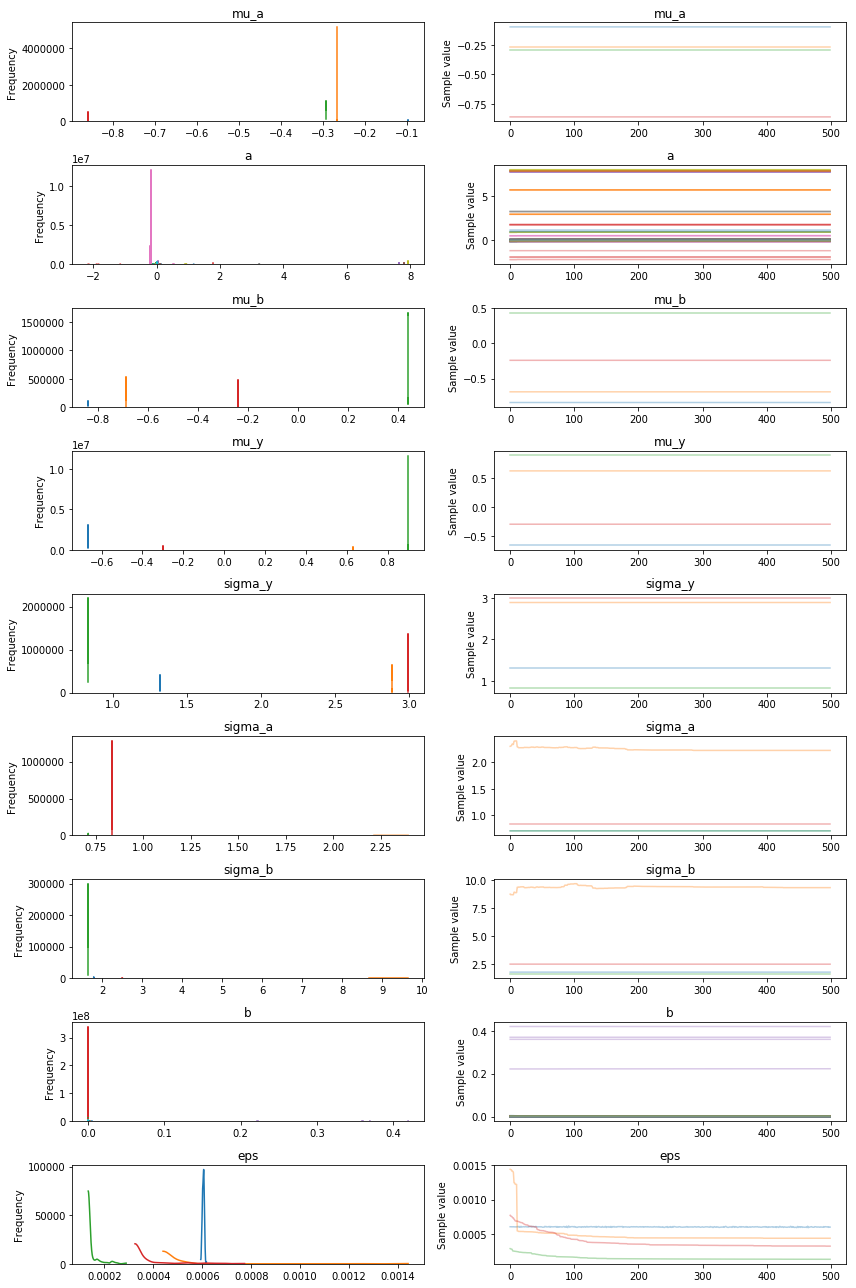

In [10]:
pm.traceplot(trace_alpha);

# Drug Gene Distributions

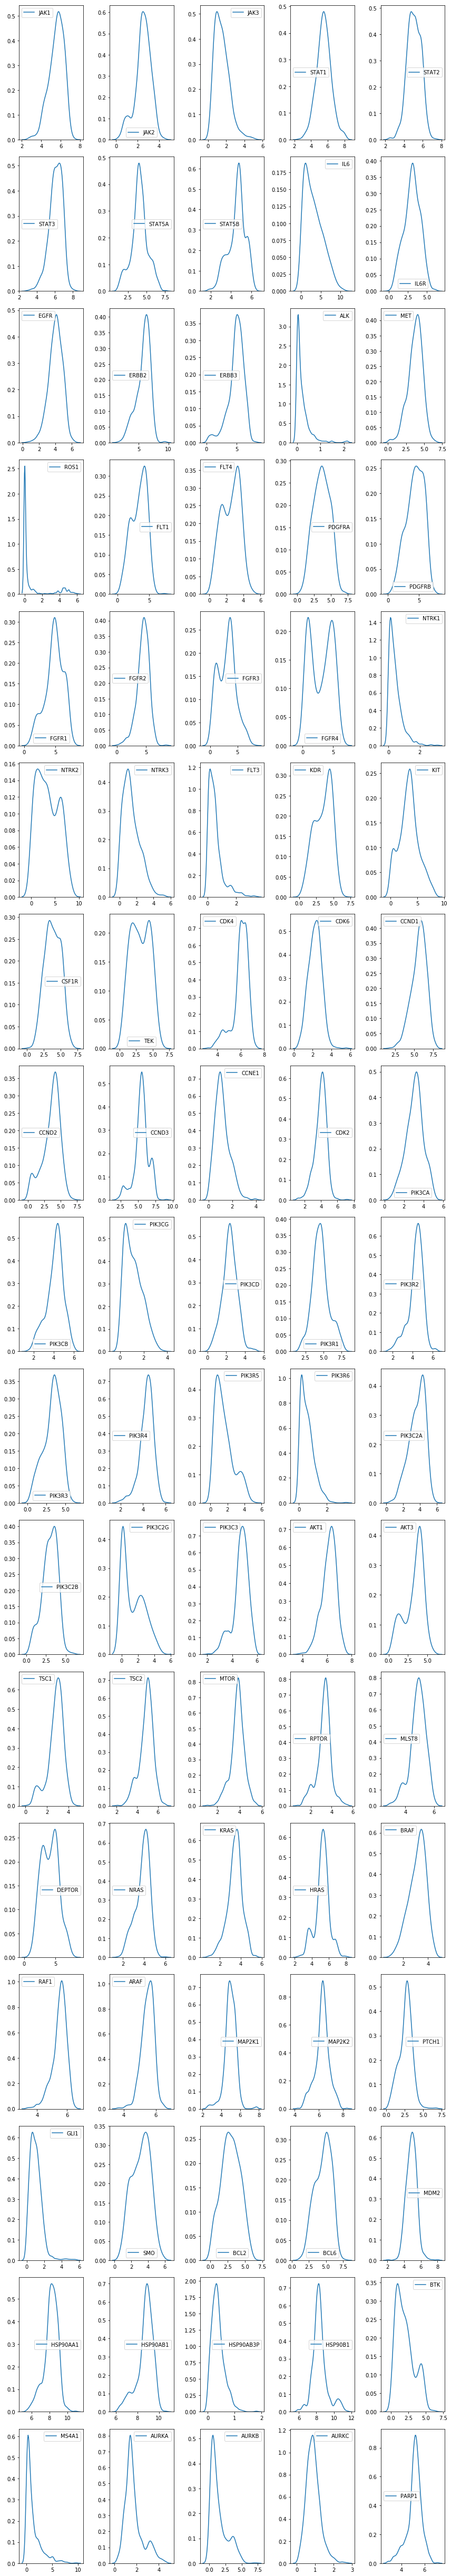

In [119]:
f, ax = plt.subplots(17, 5, figsize=(12, 4*17))
ax = ax.flatten()
for i, d in enumerate(drug_genes):
    sns.kdeplot(normal[d], ax=ax[i])
plt.tight_layout()